# Task

В этот раз у нас ядрёный датасэт о рекламах

Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (те, кто разместил эти объявления).

ads_data.csv – данные взаимодействий с рекламными объявлениями
* date – дата
* time – время
* event – действие (просмотр/клик)
* platform – платформа
* ad_id – id объявления
* client_union_id – id рекламного кабинета
* campaign_union_id – id рекламной кампании
* ad_cost_type – тип оплаты
* ad_cost – цена
* has_video – есть ли видео
* target_audience_count – размер аудитории

ads_clients_data.csv – характеристики рекламных клиентов
* date – дата
* client_union_id – id рекламного кабинета
* community_id – id сообщества
* create_date – дата создания рекламного клиента

1) Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

2) Давайте посмотрим на распределение показов обьявлений! По оси x - число показов, по оси y - доля обьявлений с такими показами. Постройте график, где значения предварительно прологорифмированы.

3) А теперь давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

4) Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. 

5) *Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименишим количеством показов) в день, в который была замечена самая большая по модулю аномалия. 

6) *Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

7) *Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате `pd.Timedelta(365, unit='d')`

8) *Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода `pd.cut` – `[0, 30, 90, 180, 365]`

9) *А теперь давайте выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

Подгрузим нужные библиотеки:

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import zipfile # Чтобы открыть csv в zip файле

Считаем данные:

In [209]:
zf = zipfile.ZipFile('ads.zip') 
ads_data = pd.read_csv(zf.open('ads_data.csv'))
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


**Задача 1.**

In [210]:
gap_data = ads_data.pivot_table(index='ad_id',
                    columns='event',
                    values='has_video',
                    aggfunc='count',
                    fill_value=0).reset_index()

gap_data.head()

event,ad_id,click,view
0,2,1,101
1,3,3,184
2,1902,1,41
3,2064,0,35
4,2132,1,58


In [211]:
round(gap_data.click.mean()) # Среднее количество кликов

113

In [212]:
round(gap_data.view.mean()) # Среднее количество показов

923

**Задача 2.**

Чтобы логарифмировать, сначала избавимся от нулевых значений:

In [213]:
gap_data.view = gap_data.view[gap_data.view != 0]

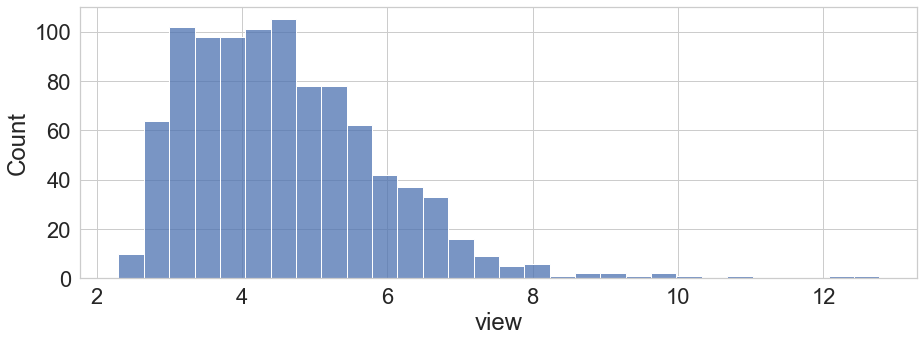

In [214]:
plt.figure(figsize=(15,5))
sns.histplot(data=np.log(gap_data.view))
sns.set(font_scale=2,
       style='whitegrid',
       rc={'figure.figsize': (20, 7)}
       )

**Задача 3.**

In [216]:
mean_by_date = ads_data.query("event == 'view'").groupby(['date', 'ad_id'], as_index=False) \
    .agg({'event': 'count'}).groupby('date', as_index=False).agg({'event': 'mean'})


mean_by_date # Средние для каждой даты

,date,event
0,2019-04-01,154.482270
1,2019-04-02,137.786982
2,2019-04-03,163.952778
3,2019-04-04,675.901720
4,2019-04-05,919.109677
5,2019-04-06,277.122727


In [217]:
mean_by_date['roll_sum'] = mean_by_date.event.rolling(2).mean() # Скользящие средние для каждой даты

round(mean_by_date['roll_sum'].tail(1))

5    598.0
Name: roll_sum, dtype: float64

**Задача 4.**

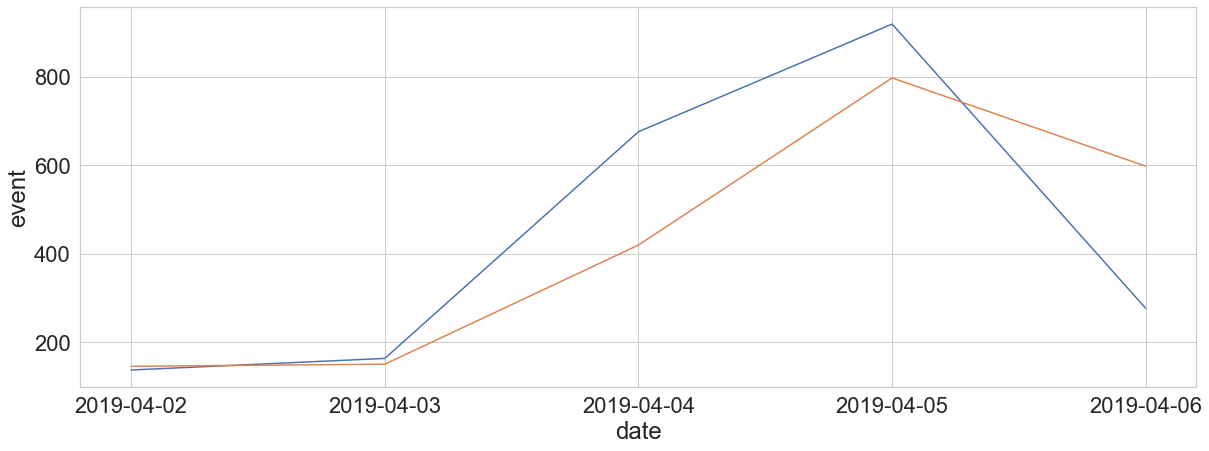

In [222]:
sns.lineplot(x=mean_by_date.date[1:], y=mean_by_date.event[1:])
sns.lineplot(x=mean_by_date.date[1:], y=mean_by_date.roll_sum[1:]);

# Отсюда видно, что это было 6 - ого апреля 2019 года

**Задача 5.**

По графику выше уже очевидно, в какой день была аномалия. Чтобы код не выглядел громоздко, не будем заново писать скрипт для поиска аномального дня. Функцию также писать бессмысленно.

In [230]:
find_problem_ad() # ad_id с максимальным количеством показов

191    112583
Name: ad_id, dtype: int64

In [231]:
find_problem_ad(False) # ad_id с минимальным количеством показов

156    98274
Name: ad_id, dtype: int64

**Задача 6.**

In [99]:
zf = zipfile.ZipFile('ads.zip') 
ads_clients_data = pd.read_csv(zf.open('ads_clients_data.csv'))
ads_clients_data.head(10)

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08
5,2020-05-07,6,-130524242,2018-10-30
6,2020-05-07,7,-130404850,2019-01-22
7,2020-05-07,8,-130811444,2018-12-11
8,2020-05-07,9,-130215524,2018-12-10
9,2020-05-07,10,-130553815,2018-12-07


In [241]:
data = ads_clients_data.merge(ads_data, how='left', on='client_union_id')
data.head()

,date_x,client_union_id,community_id,create_date,date_y,time,event,platform,ad_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:08:51,view,android,3.0,1.0,CPC,46.7,0.0,45035.0
1,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:09:36,view,ios,3.0,1.0,CPC,46.7,0.0,45035.0
2,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:30,view,ios,3.0,1.0,CPC,46.7,0.0,45035.0
3,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:29:58,view,android,3.0,1.0,CPC,46.7,0.0,45035.0
4,2020-05-07,1,-130371893,2018-12-24,2019-04-01,2019-04-01 00:51:54,view,android,3.0,1.0,CPC,46.7,0.0,45035.0


In [ ]:
data.groupbyor